# Proposal

## Introduction

Heart disease is a general term for a variety of conditions that affect your heart and blood vessels. These conditions can damage your heart, restrict blood flow, and lead to serious complications, including heart attack, stroke, and heart failure. With 20.5 million U.S. adults have coronary artery disease, heart disease is the leading cause of death in the United States (U.S. Department of Health and Human Services, 2023). 

Age is a major risk factor for heart disease due to several factors. Arteries stiffen and weaken, reducing blood flow and putting strain on the heart. Plaque buildup in arteries worsens with age, further restricting blood flow and increasing the risk of heart attack and stroke (Rodgers, J. L. et al., 2019).

Chronically high blood pressure significantly increases the risk of heart disease in several ways. It forces the heart to work harder, potentially leading to heart failure (World Health Organization, 2020). It can also damage arteries, making them more prone to plaque buildup and narrowing (Centers for Disease Control and Prevention, 2021).

High levels of LDL cholesterol, often called "bad" cholesterol, can contribute to heart disease by accumulating in arteries and forming plaque. This plaque narrows the arteries, reducing blood flow and increasing the risk of complications like chest pain, blood clots, heart attack, and stroke(Centers for Disease Control and Prevention, 2017).

Based on the research our team found, we will be using the UC Irvine Heart Disease dataset in order to answer the following research quesion.

**Research Question:** Can we classify if a patient has heart disease based on age, blood pressure and cholestrol? 

## Exploratory Data Analysis

In [27]:
library(tidyverse)
library(repr)
library(tidymodels)
library(janitor) #Install to use the clean_names() 

In [33]:
#The data set for heart disease was upload first to GitHub and, using the GitHub link, we read the file with the read_csv function. 
heart <- read_csv("data/Heart_Disease_Prediction.csv") 
#Cleaning the names
heart <- clean_names(heart)

#Converting the heart_disease variable to be a factor instead of character
heart <- heart |>
mutate(heart_disease = as_factor(heart_disease))

#Splitting the data into the training data and testing data
#Training data is 80% and the testing data is 20%
heart_split <- initial_split(heart, prop = 0.80, strata = heart_disease)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

#Selecting the variables that we are using for our prediction and plot
heart_filtered <- heart_train |>
select(age, bp, cholesterol, heart_disease)

#Getting the summary statistics for the average in each variable, exlcuding heart_disease
heart_mean <- heart_filtered|>
select(-heart_disease) |>
map_df(mean)

#Counting the number of heart disease present or absent in the training data set
heart_amount <- heart_filtered|>
group_by(heart_disease) |>
summarize(amount=n())

#Combining the two data frames together to create single table of data anaklysis
heart_summary <- bind_cols(heart_mean, heart_amount) |>
pivot_wider(names_from=heart_disease,
            values_from=amount) |>
rename(age_avg=age, bp_avg=bp, chol_avg=cholesterol, hd_absence=Absence, hd_presence=Presence)

heart_summary

#
#Using group_by(), to create two subsets and calculating the average for each variable
heart_summary_2 <- heart_train |>
group_by(heart_disease) |>
summarize(patients = n(),
         avg_age = mean(age),
         chol_avg = mean(cholesterol),
         bp_avg = mean(bp))

heart_summary_2

Rows: 270 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Heart Disease
dbl (13): Age, Sex, Chest pain type, BP, Cholesterol, FBS over 120, EKG resu...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age_avg,bp_avg,chol_avg,hd_presence,hd_absence
<dbl>,<dbl>,<dbl>,<int>,<int>
54.42593,131.3843,246.7731,96,120


heart_disease,num_patient,avg_age,chol_avg,bp_avg
<fct>,<int>,<dbl>,<dbl>,<dbl>
Presence,96,56.51042,253.3750,134.6042
Absence,120,52.75833,241.4917,128.8083


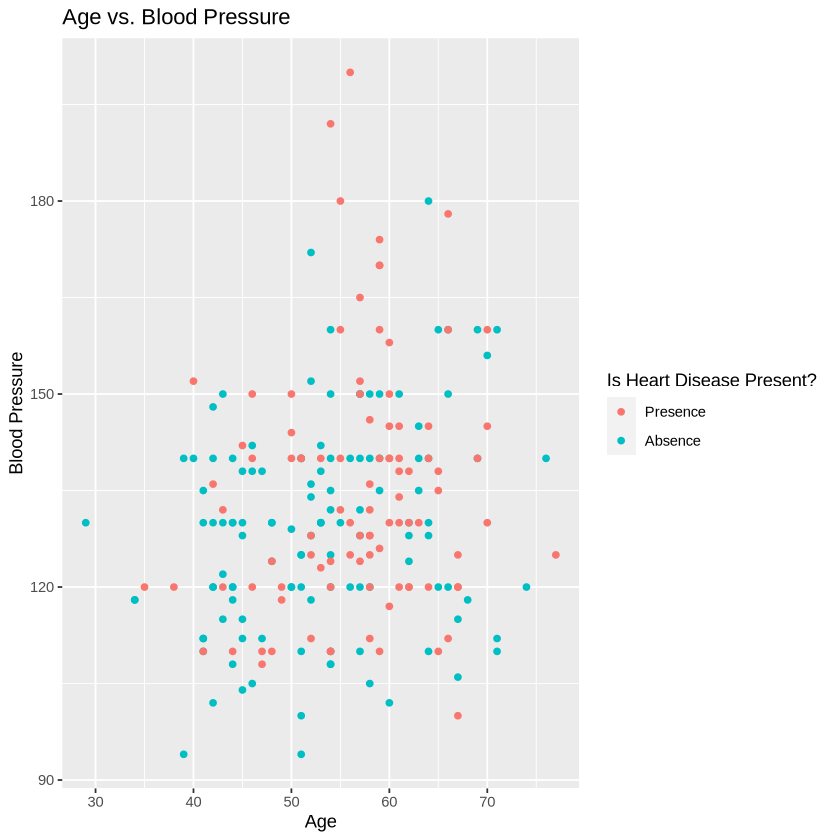

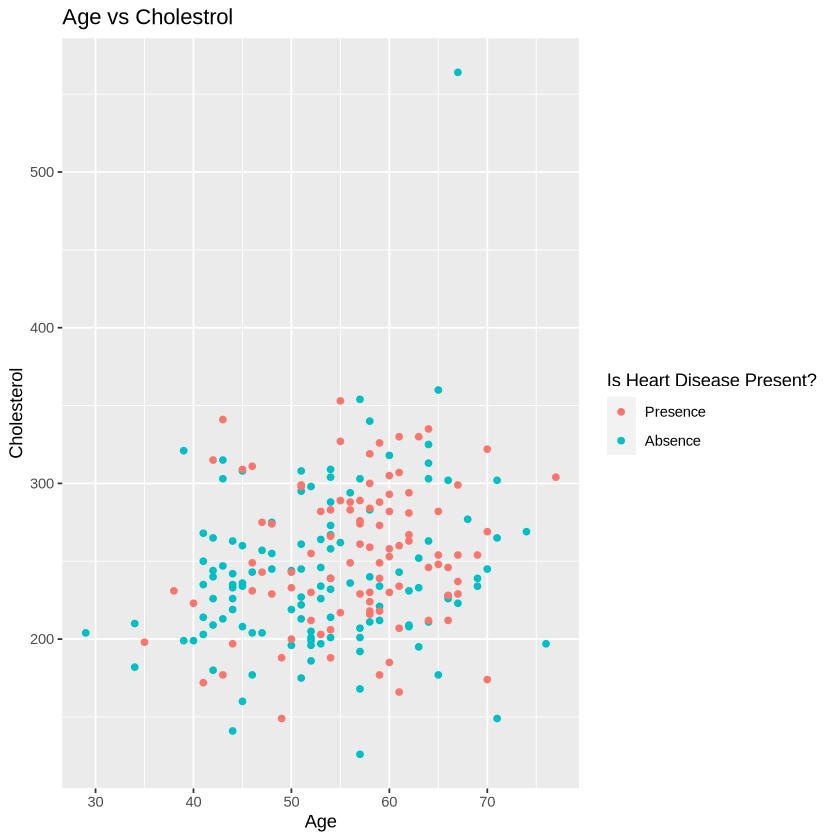

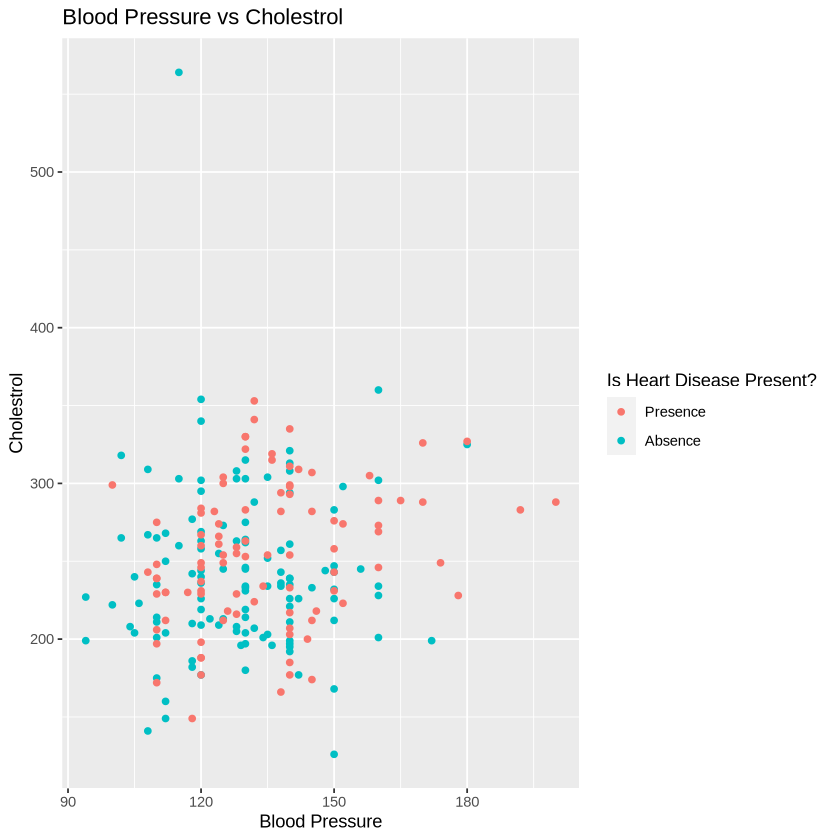

In [7]:
age_bp_plot <- ggplot(heart_filtered, aes(x = age, y = bp, color = heart_disease)) +
                geom_point()+
                labs(x = "Age", y = "Blood Pressure", color = "Is Heart Disease Present?")+
                ggtitle("Age vs. Blood Pressure")
age_bp_plot

age_chol_plot <- ggplot(heart_filtered, aes(x = age, y = cholesterol, color = heart_disease)) +
                geom_point()+
                labs(x = "Age", y = "Cholesterol", color = "Is Heart Disease Present?")+
                ggtitle("Age vs Cholestrol")
age_chol_plot

chol_bp_plot <- ggplot(heart_filtered, aes(x = bp, y = cholesterol, color = heart_disease)) +
                geom_point()+
                labs(x = "Blood Pressure", y = "Cholestrol", color = "Is Heart Disease Present?")+
                ggtitle("Blood Pressure vs Cholestrol")
chol_bp_plot


# Expected outcomes and significance:
Our research question aims to find the link between cholesterol, blood pressure, age and heart disease. Based on previous research, we are aware that cholesterol, blood pressure, and age have a significant affect on your health, but specifically the likelihood of having heart disease. With our research, we wish to determine if we can classify if a person has heart disease based on the values of those variables. The impact of this is that we can become aware of any serious health issues that may arise before it is too late. If we are successful in determining the relationship between these variables, in the future we could add more factors to these predictions and find out if there are more outstanding factors that contribute to having heart disease.


## Biblography

Centers for Disease Control and Prevention. (2017). LDL & HDL: Good & Bad Cholesterol. Centers for Disease Control and Prevention. https://www.cdc.gov/cholesterol/ldl_hdl.htm 

Centers for Disease Control and Prevention. (2021, May 18). About high blood pressure (hypertension). Centers for Disease Control and Prevention. https://www.cdc.gov/bloodpressure/about.htm

Rodgers, J. L., Jones, J., Bolleddu, S. I., Vanthenapalli, S., Rodgers, L. E., Shah, K., Karia, K., & Panguluri, S. K. (2019). Cardiovascular Risks Associated with Gender and Aging. Journal of Cardiovascular Development and Disease, 6(2). https://doi.org/10.3390/jcdd6020019

U.S. Department of Health and Human Services. (2023, December 20). What is coronary heart disease?. National Heart Lung and Blood Institute. https://www.nhlbi.nih.gov/health/coronary-heart-disease

World Health Organization. (2020). Hypertension. World Health Organization. https://www.who.int/health-topics/hypertension#tab=tab_1